https://github.com/rolling-scopes-school/ml-intro/tree/2021/5_classification_linear_knn

https://www.kaggle.com/c/titanic/data

In [ ]:
import sklearn
sklearn.__version__

# Classification. Linear models and KNN

In [ ]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OrdinalEncoder, OneHotEncoder

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression, mutual_info_classif
from sklearn.model_selection import GridSearchCV
from sklearn import metrics

In [ ]:
# some imports for my accomplishments

# standard imports
import re
import time
import random
import string

# interactive plots
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly import figure_factory as FF
# pd.options.plotting.backend = "plotly"

# progress bars
from tqdm import tqdm
tqdm.pandas()

# feature importance
import eli5
from eli5.sklearn import PermutationImportance
from yellowbrick.model_selection import FeatureImportances

# logging
import logging
logging.basicConfig()
logging.getLogger().setLevel(logging.INFO)

In [ ]:
SEED = 42

In [ ]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)


seed_everything()

In [ ]:
def fit_plot_confusion(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train % 2)

    mean, std = clf.cv_results_['mean_test_score'][clf.best_index_], \
                clf.cv_results_['std_test_score'][clf.best_index_]

    logging.info(clf.best_params_)

    disp = metrics.plot_confusion_matrix(clf, X_test, y_test % 2, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return clf.best_estimator_, {"mean": mean, "std": std}

In [ ]:
# write func for creating submission file
def write_to_submission_file(predicted_labels, out_file, train_num=891,
                    target='Survived', index_label="PassengerId"):
    # turn predictions into data frame and save as csv file
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(train_num + 1,
                                                  train_num + 1 +
                                                  predicted_labels.shape[0]),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

## Part 1: Titanic survival prediction

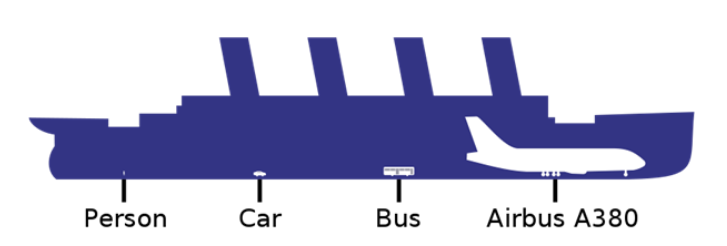

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [ ]:
# PATH = "./data/"
PATH = "../input/"

In [ ]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')

In [ ]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [ ]:
data.head()

# EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [ ]:
## your code
data.describe(include=['object'])

In [ ]:
data['Sex'].value_counts()

In [ ]:
fig = px.histogram(data, x="Sex", title="Distribution of passengers across gender")
fig.show()

In [ ]:
data['Survived'].value_counts()

In [ ]:
data["Survived_cat"] = ["Survived" if i == 1 else "Not Survived" for i in data["Survived"]]

In [ ]:
fig = px.histogram(data, x="Survived_cat", title="Survived passengers (target feature)")
fig.show()

In [ ]:
fig = make_subplots(rows=1, cols=2, specs=[[{"type": "pie"}, {"type": "pie"}]])



fig.add_trace(
            go.Pie(labels=data.loc[data['Sex'] == 'male']['Survived_cat'], pull = [.1, .1],
                   title = 'Male vs. Survived'), row=1, col=1)

fig.add_trace(
            go.Pie(labels=data.loc[data['Sex'] == 'female']['Survived_cat'], pull = [.07, .07],
                   title = 'Female vs. Survived'), row=1, col=2)


fig.update_layout(height=500, width=800, title_text="Gene Expression Features")
fig.show()

In [ ]:
survived_or_not_male = [0, 0]
survived_or_not_female = [0, 0]

for i in data[data["Survived_cat"] != "Survived"]["Sex"]:
    if i == "male":
        survived_or_not_male[0] += 1
    elif i == "female":
        survived_or_not_female[0] += 1

for i in data[data["Survived_cat"] == "Survived"]["Sex"]:
    if i == "male":
        survived_or_not_male[1] += 1
    elif i == "female":
        survived_or_not_female[1] += 1

In [ ]:
survived_sex = pd.DataFrame(
    data=[
        [survived_or_not_male[0], survived_or_not_female[0]],
        [survived_or_not_male[1], survived_or_not_female[1]]
    ],
    columns=['male','female'],
    index=['Not Survived', 'Survived']
)

survived_sex

< your thoughts >
As we can see from the pie charts and the generated data microframe, more women were saved, more men died.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

In [ ]:
## your code
fig = px.histogram(
    data, 
    x='Age', 
    nbins=79, 
    marginal='box',
    title='Passengers age distribution'
)

fig.show()

In [ ]:
data['Age'].describe()

In [ ]:
avg_age_survived = data[data["Survived_cat"] == "Survived"]["Age"].mean()
median_age_survived = data[data["Survived_cat"] == "Survived"]["Age"].median()
avg_age_deceased = data[data["Survived_cat"] != "Survived"]["Age"].mean()
median_age_deceased = data[data["Survived_cat"] != "Survived"]["Age"].median()

In [ ]:
print(f"Average age of survived passengers: {avg_age_survived}")
print(f"Median age of survived passengers: {median_age_survived}")
print(f"Average age of deceased passengers: {avg_age_deceased}")
print(f"Median age of deceased passengers: {median_age_deceased}")

In [ ]:
fig = px.histogram(
    data[data["Survived_cat"] == "Survived"], 
    x='Age', 
    nbins=79, 
    marginal='violin',
    title='Age distributions for survived passengers'
)

fig.show()

In [ ]:
fig = px.histogram(
    data[data["Survived_cat"] != "Survived"], 
    x='Age', 
    nbins=80, 
    marginal='violin',
    title='Age distributions for deceased passengers'
)

fig.show()

In [ ]:
x0 = data[data["Survived_cat"] == "Survived"]["Age"]
x1 = data[data["Survived_cat"] != "Survived"]["Age"]

fig = go.Figure()
fig.add_trace(go.Histogram(x=x0, name="Survived"))
fig.add_trace(go.Histogram(x=x1, name="NOT survived"))

fig.update_layout(
    barmode='stack', 
    title='Age distributions differ for survived and deceased passenger'
)
fig.show()

< your thoughts > The age distribution of surviving and deceased passengers has a number of differences.

Having carefully studied the graphs, you can see that babies have a high probability of surviving, obviously they will be given priority to a place in a lifeboat, and people aged ~ 80 years, were saved in 100% of cases.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

In [ ]:
## your code

In [ ]:
Pclass1 = data["Survived"][data["Pclass"] == 1].value_counts(normalize = True)
Pclass2 = data["Survived"][data["Pclass"] == 2].value_counts(normalize = True)
Pclass3 = data["Survived"][data["Pclass"] == 3].value_counts(normalize = True)

x0 = ['Pclass 1', 'Pclass 2', 'Pclass 3']
y0 = [Pclass1[1], Pclass2[1], Pclass3[1]]

pclass_data = [go.Bar(
    x=x0,
    y=y0
)]
layout = go.Layout(
    yaxis = dict(title = 'Survival Rates'),
    title = 'Survival by Pclass'
)
fig = go.Figure(data=pclass_data, layout=layout)

fig.show()

In [ ]:
fig = px.density_contour(
    data, 
    x="Pclass", 
    y="Survived_cat",
    height=700, 
    width=700
)
fig.update_layout(
    title='Density contours. Survived for Pclass'
)

fig.show()

In [ ]:
S = data["Survived"][data["Embarked"] == "S"].value_counts(normalize = True)
C = data["Survived"][data["Embarked"] == "C"].value_counts(normalize = True)
Q = data["Survived"][data["Embarked"] == "Q"].value_counts(normalize = True)

x0 = ['Southampton', 'Cherbourg', 'Queenstown']
y0 = [S[1], C[1], Q[1]]

emb_data = [go.Bar(
    x=x0,
    y=y0
)]
layout = go.Layout(
    yaxis = dict(title = 'Survival Rates'),
    title = 'Survival by Port of Embarkation'
)
fig = go.Figure(data=emb_data, layout = layout)

fig.show()

In [ ]:
fig = px.density_contour(
    data, 
    x="Embarked", 
    y="Survived_cat",
    height=700, 
    width=700
)
fig.update_layout(
    title='Density contours. Survived for Embarked'
)

fig.show()

In [ ]:
fig = px.density_contour(
    data, 
    x="Pclass", 
    y="Embarked", 
    color='Survived_cat',
    height=800, 
    width=800
)
fig.update_traces(
    contours_coloring="fill", 
    contours_showlabels=True
)
fig.update_layout(
    title='Density contours. Survived for Embarked vs. Pclass',
    legend=dict(
        x=0,
        y=.5,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)

fig.show()

In [ ]:
fig = px.density_heatmap(
    data, 
    x="Embarked", 
    y="Pclass",
    height=700, 
    width=700
)
fig.update_layout(
    title='Heatmap'
)

fig.show()

In [ ]:
fig = px.scatter_3d(
    data, 
    x='Pclass', 
    y='Embarked', 
    z='Age',
    color='Survived',
    symbol='Sex'
)
fig.update_layout(
    title='3D scatter',
    legend=dict(
        x=0,
        y=.5,
        traceorder="normal",
        font=dict(
            family="sans-serif",
            size=12,
            color="black"
        ),
    )
)

fig.show()

< your thoughts > In the first class, the chance of survival was higher than in the 3rd class. 

On heatmap we see that the most frequent pairing between Embarked and Pclass is S, 3, meaning that most passengers that embarked from Southampton were in third class.

On 3-d scatter we can clearly see that most passengers is Pclass = 3 did not survive but those that did were female. Lastly, we see that most passengers in Pclass = 1 survived indepedent of Sex

# Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [ ]:
## your code

In [ ]:
def check_missing(df):
    df_miss_numerbers = df.isna().sum()
    df_miss_percents = data.isna().mean().round(4) * 100
    miss_df=pd.concat([df_miss_numerbers, df_miss_percents], axis=1)
    miss_df.rename(columns={0: 'numbers',  1: 'percent'}, inplace=True)
    miss_df = miss_df[miss_df.numbers > 0].sort_values(by=['percent'], ascending=False)
    display(miss_df.style.background_gradient())
    miss_df.plot.bar();
#     return miss_df

In [ ]:
check_missing(data)

In [ ]:
check_missing(test_data)

In [ ]:
# almost 80% of missing values is very very bad - drop Cabin feature
# data = data.drop(columns=['Cabin'])
# test_data = test_data.drop(columns=['Cabin'])

# or not?
# for dataset in [data, test_data]:
#     dataset['Cabin'] = dataset['Cabin'].fillna('Unknown')

deck = {"A": 1, "B": 2, "C": 3, "D": 4, "E": 5, "F": 6, "G": 7, "U": 8}

for dataset in [data, test_data]:
    dataset['Cabin'] = dataset['Cabin'].fillna("U0")
    dataset['Deck'] = dataset['Cabin'].map(lambda x: re.compile("([a-zA-Z]+)").search(x).group())
    dataset['Deck'] = dataset['Deck'].map(deck)
    dataset['Deck'] = dataset['Deck'].fillna(0)
    dataset['Deck'] = dataset['Deck'].astype(int)
    
# drop Cabin feature
data = data.drop(columns=['Cabin'])
test_data = test_data.drop(columns=['Cabin'])

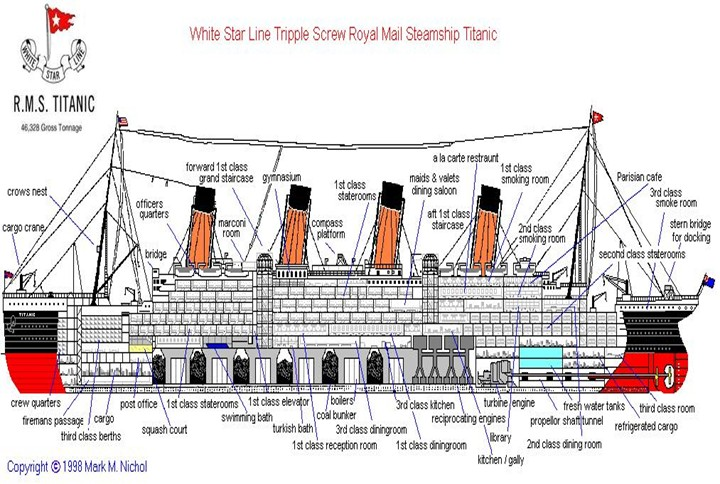

In [ ]:
# it's time to work with missing values in Age feature
age_before_imputation = data['Age'].dropna()

# Impute the missing value with the median
for dataset in [data, test_data]:
    dataset['Age'] = dataset['Age'].fillna(dataset['Age'].median())

hist_data = [age_before_imputation, data['Age']]

group_labels = ['Before imputation', 'After imputation']
colors = ['#333F44', '#37AA9C']

# Create distplot
fig = FF.create_distplot(
    hist_data,
    group_labels, 
    show_hist=False, 
    colors=colors
)

fig['layout'].update(title='Age distribution')

fig.show()

In [ ]:
# Confirm missing values of Age have been taken care of
np.sum(data['Age'].isnull())

In [ ]:
data['Embarked'].value_counts()

It's time to deal with Embarked and fill in the missing values. We will do it very simply, find the most frequent value and replace the gaps with it - Southampton(S).

In [ ]:
embarked_before_imputation = go.Histogram(
    x=data['Embarked'].dropna(),
    name='Before Imputation',
)

# Impute the Embarked variable
for dataset in [data, test_data]:
    dataset['Embarked'] = dataset['Embarked'].fillna('S')

embarked_after_imputation = go.Histogram(
    x=data['Embarked'],
    name='After Imputation'
)

embarked_before_after_imputation = [embarked_before_imputation, embarked_after_imputation]

layout = go.Layout(
    bargap = 0.5,
    barmode='group',
    title='Passenger distribution by Port of Embarkation')

fig = go.Figure(data=embarked_before_after_imputation, layout=layout)

fig.show()

In [ ]:
# Confirm missing values of Embarked have been taken care of
np.sum(data['Embarked'].isnull())

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

Thinking about ways to handle missing values is a useful thing, but I decided to go straight to business as soon as I saw them =) and, as you can see from the code above, I processed these values.

Filled in the missing values of **Age** with the median. 

I filled in the missing values port of **Embarkation** with the most common value - S (Southampton), because the percentage of skips for this feature was extremely low. 

For the missing values of **Cabin**, more radical measures were taken - the entire column was droped, because the percentage of omissions was almost 80%, which is a lot.

*What are their advantages and disadvantages?*

To try to understand the advantages and disadvantages of certain methods of handling missing values, we must understand the reason for the loss of data.

* **Missing at Random (MAR):** Missing at random means that the propensity for a data point to be missing is not related to the missing data, but it is related to some of the observed data
* **Missing Completely at Random (MCAR):** The fact that a certain value is missing has nothing to do with its hypothetical value and with the values of other variables.
* **Missing not at Random (MNAR):** Two possible reasons are that the missing value depends on the hypothetical value (e.g. People with high salaries generally do not want to reveal their incomes in surveys) or missing value is dependent on some other variable’s value (e.g. Let’s assume that females generally don’t want to reveal their ages! Here the missing value in age variable is impacted by gender variable)

In the first two cases, it is safe to remove the data with missing values depending upon their occurrences, while in the third case removing observations with missing values can produce a bias in the model. So we have to be really careful before removing observations. Note that imputation does not necessarily give better results.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [ ]:
y = data['Survived']

In [ ]:
## your code

# feature preparation

In [ ]:
# drop unnecessary features
prepared_data = data.drop(['Name', 'Ticket', 'Survived_cat'], axis=1)

In [ ]:
# encode features
prepared_data = pd.get_dummies(prepared_data)

In [ ]:
prepared_data.sample(3)

In [ ]:
# Looks good, let's now see the correlations for all features
def plot_corr_matr(c_matr):
    f, ax = plt.subplots(figsize=(16, 14))
    matrix_tr = np.triu(c_matr)

    sns.heatmap(
        c_matr, 
        mask=matrix_tr, 
        cmap=sns.diverging_palette(220, 10, as_cmap=True),
        linewidths=0.5,
        square=True, 
        ax=ax,
        annot=True
    );

In [ ]:
prepared_data.corr().abs().unstack().sort_values(ascending=False)[
    len(prepared_data.corr().columns):len(prepared_data.corr().columns) + 10
]

In [ ]:
corr_matrix = prepared_data.corr(method='pearson').abs()

In [ ]:
plot_corr_matr(corr_matrix)

# train Logistic Regression

In [ ]:
X = prepared_data.drop(columns=['Survived'])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [ ]:
print(f'Training sample dimension: {X_train.shape}')
print(f'Validation sample dimension: {X_valid.shape}')

In [ ]:
log_reg_model = LogisticRegression(solver='liblinear', penalty='l1')

In [ ]:
log_reg_model.fit(X_train, y_train)

log_reg_prediction = log_reg_model.predict(X_valid)
accuracy_score(y_valid, log_reg_prediction)

In [ ]:
pipeline_mms = make_pipeline(MinMaxScaler(), log_reg_model)
pipeline_mms.fit(X_train, y_train)
mms_log_reg_prediction = pipeline_mms.predict(X_valid)

accuracy_score(y_valid, mms_log_reg_prediction)

In [ ]:
pipeline_ss = make_pipeline(StandardScaler(), log_reg_model)
pipeline_ss.fit(X_train, y_train)
ss_log_reg_prediction = pipeline_ss.predict(X_valid)

accuracy_score(y_valid, ss_log_reg_prediction)

In [ ]:
forest_model = RandomForestClassifier(random_state=SEED)

In [ ]:
pipeline_mms_fs = make_pipeline(MinMaxScaler(), SelectFromModel(forest_model), log_reg_model) 
pipeline_mms_fs.fit(X_train, y_train)
mms_forest_log_reg_pred = pipeline_mms_fs.predict(X_valid)

accuracy_score(y_valid, mms_forest_log_reg_pred)

In [ ]:
pipeline_ss_fs = make_pipeline(StandardScaler(), SelectFromModel(forest_model), log_reg_model) 
pipeline_ss_fs.fit(X_train, y_train)
ss_forest_log_reg_pred = pipeline_ss_fs.predict(X_valid)

accuracy_score(y_valid, ss_forest_log_reg_pred)

# train KNN

In [ ]:
knn_model = KNeighborsClassifier(n_neighbors=5)

In [ ]:
knn_model.fit(X_train, y_train)

knn_prediction = knn_model.predict(X_valid)
accuracy_score(y_valid, knn_prediction)

In [ ]:
pipeline_mms_knn = make_pipeline(MinMaxScaler(), knn_model)
pipeline_mms_knn.fit(X_train, y_train)
mms_knn_prediction = pipeline_mms_knn.predict(X_valid)

accuracy_score(y_valid, mms_knn_prediction)

In [ ]:
pipeline_ss_knn = make_pipeline(StandardScaler(), knn_model)
pipeline_ss_knn.fit(X_train, y_train)
ss_knn_prediction = pipeline_ss_knn.predict(X_valid)

accuracy_score(y_valid, ss_knn_prediction)

In [ ]:
pipeline_mms_fs_knn = make_pipeline(MinMaxScaler(), SelectFromModel(forest_model), knn_model) 
pipeline_mms_fs_knn.fit(X_train, y_train)
knn_mms_forest_pred = pipeline_mms_fs_knn.predict(X_valid)

accuracy_score(y_valid, knn_mms_forest_pred)

In [ ]:
pipeline_ss_fs_knn = make_pipeline(StandardScaler(), SelectFromModel(forest_model), knn_model) 
pipeline_ss_fs_knn.fit(X_train, y_train)
knn_ss_forest_pred = pipeline_ss_fs_knn.predict(X_valid)

accuracy_score(y_valid, knn_ss_forest_pred)

In [ ]:
pipeline_ss_knn_lr = make_pipeline(StandardScaler(), SelectFromModel(log_reg_model), knn_model) 
pipeline_ss_knn_lr.fit(X_train, y_train)
ss_knn_lr_pred = pipeline_ss_knn_lr.predict(X_valid)

accuracy_score(y_valid, ss_knn_lr_pred)

In [ ]:
pipeline_mms_knn_lr = make_pipeline(MinMaxScaler(), SelectFromModel(log_reg_model), knn_model) 
pipeline_mms_knn_lr.fit(X_train, y_train)
mms_knn_lr_pred = pipeline_mms_knn_lr.predict(X_valid)

accuracy_score(y_valid, mms_knn_lr_pred)

Results not so good, need to work hard! =)

# feature enginering

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [ ]:
## your code

In [ ]:
# prepare new set and drop unnecessary features
fe_prepared_test_data = test_data.copy()

fe_prepared_data = data.drop(['Survived_cat'], axis=1)
fe_prepared_data.head()

In [ ]:
# generate new feature from Name column
# see honorific and titles in names of passengers.
fe_prepared_data['Name'].str.extract('([A-Za-z]+)\.', expand=False).unique()

In [ ]:
# add Title as new feature
for dataset in [fe_prepared_data, fe_prepared_test_data]:
    dataset['Title'] = dataset['Name'].str.extract('([A-Za-z]+)\.', expand=False)

In [ ]:
fe_prepared_data['Title'].value_counts()

In [ ]:
# reduce the number of values, otherwise it hurts a lot
# replace those that are rare with rare ones, the rest will be called common names.
for dataset in [fe_prepared_data, fe_prepared_test_data]:
    dataset['Title'] = dataset['Title'].replace(
        ['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 
        'Rare'
    )

    dataset['Title'] = dataset['Title'].replace('Mlle', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Ms', 'Miss')
    dataset['Title'] = dataset['Title'].replace('Mme', 'Mrs')

In [ ]:
# check the survivability of each Title group
fe_prepared_data[['Title', 'Survived']].groupby(
    ['Title'], 
    as_index=False
).mean().sort_values(by='Survived', ascending=False)

In [ ]:
# add IsMarried feature
for dataset in [fe_prepared_data, fe_prepared_test_data]:
    dataset['Is_Married'] = 0
    dataset['Is_Married'].loc[dataset['Title'] == 'Mrs'] = 1

In [ ]:
# check the survivability of each Is_Married group
fe_prepared_data[['Is_Married', 'Survived']].groupby(
    ['Is_Married'], 
    as_index=False
).mean().sort_values(by='Survived', ascending=False)

In [ ]:
for dataset in [fe_prepared_data, fe_prepared_test_data]:
    # create feature FamilySize
    dataset['FamilySize'] = dataset['SibSp'] + dataset['Parch'] + 1

    # create feature Alone from FamilySize
    dataset['Alone'] = 0
    dataset.loc[dataset['FamilySize'] == 1, 'Alone'] = 1

In [ ]:
# check the survivability of each Alone group
fe_prepared_data[['Alone', 'Survived']].groupby(
    ['Alone'], 
    as_index=False
).mean().sort_values(by='Survived', ascending=False)

In [ ]:
# check the survivability of each FamilySize group
fe_prepared_data[['FamilySize', 'Survived']].groupby(
    ['FamilySize'], 
    as_index=False
).mean().sort_values(by='Survived', ascending=False)

In [ ]:
# creating feature isGreen based on passengers under 16 y.o.
for dataset in [fe_prepared_data, fe_prepared_test_data]:
    dataset['isGreen'] = np.where(dataset['Age'] <= 16, 1, 0)

In [ ]:
# creating features based on some common words in Ticket
for dataset in [fe_prepared_data, fe_prepared_test_data]:
    dataset['CA'] = dataset['Ticket'].str.contains('CA|C.A.').astype(int)
    dataset['SOTON'] = dataset['Ticket'].str.contains('SOTON|STON').astype(int)
    dataset['PC'] = dataset['Ticket'].str.contains('PC').astype(int)
    dataset['SC'] = dataset['Ticket'].str.contains('SC|S.C').astype(int)
    dataset['C'] = dataset['Ticket'].str.contains('C').astype(int)

fe_prepared_data = fe_prepared_data.drop(['Ticket'], axis=1)
fe_prepared_test_data = fe_prepared_test_data.drop(['Ticket'], axis=1)

In [ ]:
# Impute the Fare variable on test dataset
fe_prepared_test_data['Fare'] = fe_prepared_test_data['Fare'].fillna(
    fe_prepared_test_data['Fare'].median()
)

In [ ]:
# create temp feature based on Fare
fe_prepared_data['tempFare'] = pd.qcut(fe_prepared_data['Fare'], 8)
fe_prepared_data[['tempFare', 'Survived']].groupby(
    ['tempFare'], 
    as_index=False
).mean().sort_values(by='tempFare', ascending=True)

In [ ]:
# replace Fare value based on tempFare
for dataset in [fe_prepared_data, fe_prepared_test_data]:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare'] = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

# drop temp feature    
fe_prepared_data = fe_prepared_data.drop(['tempFare'], axis=1)

In [ ]:
# for dataset in [fe_prepared_data, fe_prepared_test_data]:
#     # create categorical feature of Pclass
#     dataset["Pclass_cat"] = [
#         "1st" if i == 1 else "2nd" if i == 2 else "3rd" for i in dataset["Pclass"]
#     ]

In [ ]:
# drop garbage
fe_prepared_data = fe_prepared_data.drop(['Name', ], axis=1)
# fe_prepared_data = fe_prepared_data.drop(['Pclass', 'Parch', 'SibSp', 'FamilySize'], axis=1)

fe_prepared_test_data = fe_prepared_test_data.drop(['Name', ], axis=1)
# fe_prepared_test_data = fe_prepared_test_data.drop(['Pclass', 'Parch', 'SibSp', 'FamilySize'], axis=1)

fe_prepared_data.head()

In [ ]:
# create temp feature based on Age
fe_prepared_data['AgeGroup'] = pd.cut(fe_prepared_data ['Age'], 8)
fe_prepared_data[['AgeGroup', 'Survived']].groupby(
    ['AgeGroup'], 
    as_index=False
).mean().sort_values(by='AgeGroup', ascending=True)

In [ ]:
# replace Age value based on AgeGroup
for dataset in [fe_prepared_data, fe_prepared_test_data]:
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
    dataset['Age'] = dataset['Age'].astype(int)
    
# drop temp feature    
fe_prepared_data = fe_prepared_data.drop(['AgeGroup'], axis=1)

In [ ]:
for dataset in [fe_prepared_data, fe_prepared_test_data]:
    dataset['Age*Class'] = dataset['Age'] * dataset['Pclass']

fe_prepared_data.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

In [ ]:
# Fare per Person
for dataset in [fe_prepared_data, fe_prepared_test_data]:
    dataset['Fare_Per_Person'] = dataset['Fare'] / (dataset['FamilySize'])
    dataset['Fare_Per_Person'] = dataset['Fare_Per_Person'].astype(int)

In [ ]:
for dataset in [fe_prepared_data, fe_prepared_test_data]:
#     # encode features
    dataset['Sex'] = dataset['Sex'].map({'male': 1, 'female': 0})
    dataset['Embarked'] = dataset['Embarked'].map({'S': 0, 'C': 1, 'Q': 2})
    dataset['Title'] = dataset['Title'].map(
        {"Mr": 1, "Miss": 2, "Mrs": 3, "Master": 4, "Rare": 5}
    )

fe_prepared_data = pd.get_dummies(fe_prepared_data)

fe_prepared_test_data = pd.get_dummies(fe_prepared_test_data)

fe_prepared_data.head()

In [ ]:
fe_prepared_data.columns

In [ ]:
fe_prepared_test_data.columns

In [ ]:
X = fe_prepared_data.drop(columns=['Survived'])

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [ ]:
log_reg_model = LogisticRegression(C=1.1, solver='liblinear', penalty='l2')

fe_pipeline_ss = make_pipeline(StandardScaler(), log_reg_model)
fe_pipeline_ss.fit(X_train, y_train)
fe_ss_log_reg_prediction = fe_pipeline_ss.predict(X_valid)

accuracy_score(y_valid, fe_ss_log_reg_prediction)

# try to find best hyperparameters

In [ ]:
# best_feats = X.columns.tolist()

In [ ]:
best_feats = [
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked',
    'Title',
    'Is_Married',
    'FamilySize',
    'Alone',
    'isGreen',
    'CA',
    'SOTON',
    'PC',
    'SC',
    'Age*Class',
]

In [ ]:
X_train[best_feats].sample(3)

In [ ]:
# re-create the model by specifying a solver
clf = LogisticRegression(solver='liblinear')

# describe the grid on which we will search
param_grid = {
    'logreg__solver': ['liblinear'],
    'logreg__C': np.logspace(-4, 4, 20),
    'logreg__penalty': ['l1', 'l2'],
    'logreg__random_state': [17, 21, 42, 73, 2020],
    'logreg__fit_intercept': [True, False],
    'logreg__class_weight': [None, 'balanced'],
    'logreg__max_iter': [2500, 3000, 3500],
}

pipe_for_grid = Pipeline([('scaler',  StandardScaler()), ('logreg', clf)])
# create a GridSearchCV object
log_reg_grid_search = GridSearchCV(
    pipe_for_grid, param_grid, n_jobs=-1, cv=5, refit=True, scoring='accuracy'
)

# run search
log_reg_grid_search.fit(X_train[best_feats], y_train)

best_model = log_reg_grid_search.best_estimator_

# display the best parameters
print(f"Best params: {log_reg_grid_search.best_params_}")
print(f"Best score: {log_reg_grid_search.best_score_}")
print(f"Best estimator: {best_model}")
log_reg_grid_prediction = best_model.predict(X_valid[best_feats])
print(f"CV accuracy score: {accuracy_score(y_valid, log_reg_grid_prediction)}")

In [ ]:
lr_best_clf, lr_stats = fit_plot_confusion(
    log_reg_grid_search, 
    X_train[best_feats], 
    y_train, 
    X_valid[best_feats], 
    y_valid
)

In [ ]:
eli_lr_model = best_model


eli_lr_model.fit(X_train[best_feats], y_train)
perm = PermutationImportance(eli_lr_model).fit(X_valid[best_feats], y_valid)
eli5.show_weights(perm, feature_names = best_feats)

In [ ]:
model_yb = eli_lr_model[1]
viz = FeatureImportances(model_yb)
viz.fit(X_train[best_feats], y_train)

viz.show();
# https://www.scikit-yb.org/en/latest/api/model_selection/importances.html

In [ ]:
# KNN

knn_param_grid = {
    'n_neighbors': [1, 2, 3, 5, 30, 100], 
    'weights': ['uniform', 'distance']
}

knn_clf = GridSearchCV(KNeighborsClassifier(n_jobs=-1), knn_param_grid)

knn_best_clf, knn_stats = fit_plot_confusion(
    knn_clf, 
    X_train[best_feats], 
    y_train,
    X_valid[best_feats], 
    y_valid
)

# stats and params
print(f"Knn stats: {knn_stats}")
print(f"Knn Best estimator: {knn_best_clf}")

y_pred = knn_best_clf.predict(X_valid[best_feats])

print(f"CV accuracy score: {metrics.accuracy_score(y_pred=y_pred, y_true=y_valid % 2)}")

In [ ]:
eli_lr_model = knn_best_clf

eli_lr_model.fit(X_train[best_feats], y_train)
perm = PermutationImportance(eli_lr_model).fit(X_valid[best_feats], y_valid)
eli5.show_weights(perm, feature_names = best_feats)

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

# Predict on test data

In [ ]:
fe_pipeline_full_data = make_pipeline(best_model)
# fe_pipeline_full_data = make_pipeline(knn_best_clf)

fe_pipeline_full_data.fit(X[best_feats], y)
fe_log_reg_prediction_full_data = fe_pipeline_full_data.predict(
    fe_prepared_test_data[best_feats]
)

write_to_submission_file(
    fe_log_reg_prediction_full_data, 
    'submit.csv'
)

In [ ]:
fe_pipeline_full_data

LeaderBoard Score: 0.79425

best_feats = [
    'Pclass',
    'Sex',
    'Age',
    'SibSp',
    'Parch',
    'Fare',
    'Embarked',
    'Title',
    'Is_Married',
    'FamilySize',
    'Alone',
    'isGreen',
    'CA',
    'SOTON',
    'PC',
    'SC',
    'Age*Class',
]

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('scaler', StandardScaler()),
                                 ('logreg',
                                  LogisticRegression(C=0.23357214690901212,
                                                     max_iter=3000,
                                                     random_state=17,
                                                     solver='liblinear'))]))])

<a href="./submit.csv"> Download File </a>

https://www.kaggle.com/c/titanic/submit